# TextRank
Mihalcea, R., & Tarau, P. (2004). TextRank: Bringing Order into Texts. In TextRank: Bringing Order into Texts (pp. 404–411).

TextRank is a graph-based method for unsupervised keyword and sentence extration for summarizing text.

## Algorithm

1. Identify units of text
    - E.g. words or sentences
    - TextRank selects one or more of those units as the summary
2. Define similarity between units
    - E.g. co-occurance or cosine similarity
    - The similairities determine the weights in the PageRank GoogleMatrix
3. Apply weighted PageRank
    - $WS(V_i) = (1-d) + d * \sum_{V_j \in \text{In}(V_i)} \frac{w_{ji}}{\sum_{v_k \in \text{Out}(V_j)} w_{ji}} WS(V_j)$
    - Proportional to randomly following links and counting visits
    - Considers number of in-bound links from important units
4. Select the top ranked units as the summary

## Advantages & disadvantages

- Easy to understand and implement
- and fast and scalable

But,

- only extractive summarization on pre-defined units
- state-of-the-art performance is much better

In [1]:
import re

import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt

from wikipedia import query_wikipedia
from sentence_preprocessing import split_sentences, filter_sentences, clean_sentence
from pretty_print import print_with_emphasis, print_summary
from textrank import summarize_wiki

In [2]:
with open('stopwords.json', 'r') as fin:
    STOP_WORDS = json.load(fin)

In [3]:
def sentence_similarity(sentences, stop_word_language=None):
    """Compute similarity between sentences
    
    Using:
    - cosine similarity on
    - character n-grams
    """
    stop_words = STOP_WORDS.get(stop_word_language, None)
    vectorizer = TfidfVectorizer(analyzer='char_wb', min_df=0.05, max_df=0.5, ngram_range=(3, 10), stop_words=stop_words)
    vectors = vectorizer.fit_transform(sentences)
    print(vectors.shape)
    similarity = metrics.pairwise.cosine_similarity(vectors, vectors)
    return similarity

In [4]:
def edge_weights(similarity, d=0.85):
    """Transform sentence similarities to proper normalized weights
    
    :param d: damping factor, percentage of jumps to random vertex
    """
    weights = similarity
    np.fill_diagonal(weights, 0)
    weights = normalize(weights, 'l1')
    weights = (1 - d) / weights.shape[0] + d * weights
    return weights

In [5]:
def compute_rank_naive(weights, steps=100):
    """Compute rank by iterative updating
    
    Similar to first eigenvector if the number of steps is large enough
    """
    rank = np.ones(weights.shape[0])
    for _ in range(steps):
        rank = np.array([weights[:,i].dot(vertices) for i in range(rank.shape[0])])
    return rank

In [6]:
def compute_rank_eigenvector(weights):
    """Compute rank by eigenvector decomposition"""
    eigenvalue, eigenvector = np.linalg.eig(weights.T)
    ind = eigenvalue.argmax()
    largest_vector = np.abs(eigenvector[:, ind])
    return (largest_vector - largest_vector.min()) / (largest_vector.max() - largest_vector.min())

In [7]:
text = query_wikipedia('kroatië', 'nl')
text.split('\n')[0]

'Kroatië (Kroatisch: Hrvatska, Italiaans: Croazia), officieel Republiek Kroatië (Republika Hrvatska, Repubblica di Croazia), is een land in Zuidoost-Europa. Kroatië is lid van de Europese Unie. Het grenst aan Slovenië en Hongarije in het noorden, Bosnië en Montenegro in het zuiden en Servië in het oosten. In het westen ligt de Adriatische Zee, waar de Kroatische territoriale wateren grenzen aan die van Italië. Geografisch wordt het zuidelijk deel van Kroatië gezien als onderdeel van het Balkanschiereiland. Het strekt zich uit van de uiterste oostelijke hellingen van de Alpen in het noordwesten tot de Pannonische vlakte en de Donau in het oosten. Het centrale deel wordt bedekt door de Dinarische Alpen. De hoofdstad is Zagreb, andere belangrijke steden zijn onder meer Split, Osijek en Rijeka.'

In [8]:
sentences = filter_sentences(split_sentences(text))
clean_sentences = list(map(clean_sentence, sentences))
clean_sentences[0]

'kroati   kroatisch  hrvatska  italiaans  croazia   officieel republiek kroati   republika hrvatska  repubblica di croazia   is een land in zuidoost europa'

(347, 514)


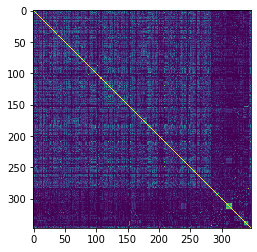

In [9]:
similarities = sentence_similarity(clean_sentences, stop_word_language='nl')
plt.imshow(similarities)

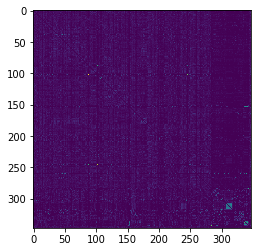

In [10]:
weights = edge_weights(similarities, d=0.85)
plt.imshow(weights)

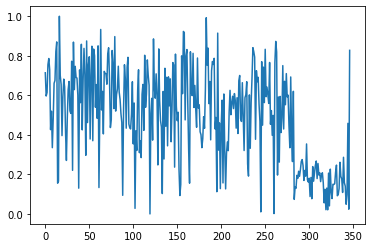

In [11]:
ranks = compute_rank_eigenvector(weights)
plt.plot(ranks)

In [12]:
print_summary(sentences, ranks)